## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [94]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [95]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [96]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [97]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    #print('add_to_dict::: Qstate---->', state1)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [98]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    #print('In epsilon_greedy:::episode-->',time)
    #print('In epsilon_greedy:::Q_dict:::', Q_dict,'   state->', state)
    result, result_val = env.is_terminal(state)
    print ('In epsilon_greedy: check state terminal-->',result, '  result_val-->',result_val)
    if result == False and result_val == 'Resume': #check the current board position, if not terminal state the proceed   
        z = np.random.random()
        epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
        if z > epsilon:
            state1 = Q_state(state)
            action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
        else:

            agent_actions, env_actions = env.action_space(state)
            agent_actions_list = list(agent_actions) # List all the possible actions for Agent
            #print('Agent action space---->',agent_actions_list)
            action = agent_actions_list[random.randrange(len(agent_actions_list))]  #Exploration: randomly choosing and action
            print ('Current action of Agent->', action)
    else:
        action = (-1,-1) # return action as (-1,-1) as terminal position has reached 
           
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [99]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

In [100]:
print (Q_dict)
print (States_track)

defaultdict(<class 'dict'>, {})
defaultdict(<class 'dict'>, {})


In [101]:
# Initialise states to be tracked
def initialise_tracking_states():
    # Defining four sample states
    sample_q_values = [('x-x-x-x-9-x-x-x-6',(0, 1)),('6-x-x-x-4-5-x-9-x',(1, 1)),('x-6-x-2-4-7-8-9-3',(0,5)),('9-7-8-6-4-x-1-x-x',(5,5))]   #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         
  
  
  

In [102]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [103]:
def save_tracking_states():
    for state in States_track.keys():        
        for action in States_track[state].keys():            
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])
    #print('In save_tracking_states--------', States_track)

In [104]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [105]:
EPISODES = 1000
STEPS = 10
LR = 0.01                   #learning rate
GAMMA = 0.91


threshold = 1       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 3    #every these many episodes, the Q-dict will be updated


### Q-update loop ---write your code here

In [106]:
start_time = time.time()

for episode in range(0,EPISODES):
    ##### Start writing your code from the next line
    
    env = TicTacToe()    
    initial_state = env.state
    curr_state = env.state    
    time_step = 0
    reward = None    
    total_reward = 0    
    
    while time_step < STEPS:    #the episode will run only for a few steps and not infinitely
        
        print("Episode:", episode, "   time_step:", time_step)
        
        add_to_dict(curr_state)
        #print ('In for loop Q_dict -->',Q_dict)
        #print ('In for loop state track -->',States_track)
        
        curr_action = epsilon_greedy(curr_state, episode)
        if curr_action != (-1, -1): # Check if terminal board position has reached
            #print ('Inside while-epsilon_greedy::: curr_state-->', curr_state, '   curr_action-->', curr_action)

            next_state, reward, stateTerminal = env.step(curr_state, curr_action)
            print ('Inside while::: after step() called:::current_state-->', curr_state, '  next_state-->', next_state, '  reward-->', reward, '  state is terminal-->', stateTerminal)

            if stateTerminal == True: # Check if the state is terminal after calling step()
                break # Move to next epsisode
            else:
                add_to_dict(next_state)

                next_state_1 = Q_state(next_state) # convert state to string form
                curr_state_1 = Q_state(curr_state) # convert state to string form
                #print('Current state->', curr_state_1, '  next_state_1->', next_state_1)
                max_next = max(Q_dict[next_state_1],key=Q_dict[next_state_1].get)   #this gets the action corresponding to max q-value of next state
                #print ('Inside while::: max_next -->',max_next)
                Q_dict[curr_state_1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_1][max_next]))) - Q_dict[curr_state_1][curr_action] ) 


            curr_state = next_state       #state(t) became state(t-1)

            total_reward += reward
            print('Total reward so far:',total_reward)

            time_step += 1
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  
        save_obj(Q_dict,'Policy')       
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print('Last episode------>', episode)

States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 0    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 9, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 8)
After state transition--> [nan, nan, nan, nan, 9, nan, nan, nan, 8]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan] 

Total reward so far: -3
Episode: 8    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 3, 6, 1, nan, 2, 8, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 4)
After state transition--> [5, 3, 6, 1, nan, 2, 8, 4, 9]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [5, 3, 6, nan, nan, 2, 8, nan, 9]   next_state--> [5, 3, 6, 1, nan, 2, 8, 4, 9]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 8    time_

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 2)
After state transition--> [nan, nan, 2, nan, nan, 9, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, 2, nan, nan, 9, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 17    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 2, nan, nan, 9, 1, nan, nan]
current state is not a winning positio

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 3, nan, 1, 9, 2, nan, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 8)
After state transition--> [nan, nan, 3, 8, 1, 9, 2, nan, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 3, nan, nan, 9, 2, nan, 4]   next_state--> [nan, nan, 3, 8, 1, 9, 2, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 25    time_step: 3
current state is not a winning position
In epsilon_greedy: check s

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 2, 9, nan, 3, nan, nan, nan, 8]   next_state--> [nan, 2, 9, nan, 3, 1, 6, nan, 8]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 33    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, 9, 5, 3, 1, 6, nan, 8]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 4)
After state transition--> [nan, 2, 9, 5, 3, 1, 6, 4, 8]
current state is not a winning position
In step - after env action -  Afte

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [nan, 2, nan, 7, 9, 8, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 2, nan, nan, 9, nan, nan, nan, nan]   next_state--> [nan, 2, nan, 7, 9, 8, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 43    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, 3, 7, 9, 8, nan, nan, nan]
current state is not a winning position
In step: after

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 4)
After state transition--> [nan, 4, nan, 6, 5, 1, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 6, nan, 1, nan, nan, nan]   next_state--> [nan, 4, nan, 6, 5, 1, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 51    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [7, 4, nan, 6, 5, 1, nan, nan, nan]
current state is not a winning position
In step: after

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, nan, 1, 9, nan, nan, nan, 7, 8]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 4)
After state transition--> [6, nan, 1, 9, nan, 4, nan, 7, 8]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [6, nan, 1, nan, nan, nan, nan, 7, 8]   next_state--> [6, nan, 1, 9, nan, 4, nan, 7, 8]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 59    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After

Total reward so far: -2
Episode: 67    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, nan, nan, 8, 2, 9, nan, nan, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 6)
After state transition--> [1, nan, 6, 8, 2, 9, nan, nan, 5]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 8, 2, 9, nan, nan, 5]   next_state--> [1, nan, 6, 8, 2, 9, nan, nan, 5]   reward--> -1   state is terminal--> False
Total reward so far: -3
Ep

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, 7, nan, nan, nan, 6]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 75    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 7, nan, 9, nan, 6]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 4)
After state transition--> [4, nan, nan, nan, 7, nan, 9, nan, 6]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
In

current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, nan, 5, 4, nan, nan, nan, 8, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 6)
After state transition--> [1, nan, 5, 4, 6, nan, nan, 8, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 5, 4, nan, nan, nan, 8, 7]   next_state--> [1, nan, 5, 4, 6, nan, nan, 8, 7]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 83    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 3)
current state is not a win

current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, 7, nan, 6, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [nan, 5, 7, nan, 6, nan, nan, 8, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 7, nan, 6, nan, nan, nan, nan]   next_state--> [nan, 5, 7, nan, 6, nan, nan, 8, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 92    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current st

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 3, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 6)
After state transition--> [nan, nan, nan, nan, 3, 6, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, 3, 6, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 100    time_step: 1
current state is not a winning po

Episode: 108    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 7, nan, 2, 5, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 4)
After state transition--> [nan, nan, 4, nan, 7, nan, 2, 5, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, 2, 5, nan]   next_state--> [nan, nan, 4, nan, 7, nan, 2, 5, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 2)
After state transition--> [5, nan, 4, 8, nan, 7, 2, nan, 3]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [5, nan, 4, 8, nan, nan, nan, nan, 3]   next_state--> [5, nan, 4, 8, nan, 7, 2, nan, 3]   reward--> -10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 117    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, n

Episode: 125    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [4, nan, nan, 3, nan, nan, nan, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 6)
After state transition--> [4, nan, nan, 3, nan, nan, 6, nan, 9]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [4, nan, nan, nan, nan, nan, nan, nan, 9]   next_state--> [4, nan, nan, 3, nan, nan, 6, nan, 9]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 

Inside while::: after step() called:::current_state--> [nan, 6, 7, 3, 2, 8, 4, 5, 1]   next_state--> [9, 6, 7, 3, 2, 8, 4, 5, 1]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 133    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, nan, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 4)
After state transition--> [nan, 3, nan, nan, nan, 4, nan, nan, nan]
current state is not a winning position
In step - after env action -  Afte

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 2)
After state transition--> [4, 9, 6, 2, 1, 8, 5, nan, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [4, nan, 6, nan, 1, 8, 5, nan, 7]   next_state--> [4, 9, 6, 2, 1, 8, 5, nan, 7]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 140    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [4, 9, 6, 2, 1, 8, 5, 3, 7]
current state is a winning position
In step: after agent action - After state transit

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, 3, 5, 9, 2, 1, 6, 4, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [8, 3, 5, 9, 2, nan, 6, 4, 7]   next_state--> [8, 3, 5, 9, 2, 1, 6, 4, 7]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 149    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 9)
current state is not a winning position
In step: initially - After state transition check state 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [2, nan, nan, nan, nan, 5, nan, 7, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 8)
After state transition--> [2, 8, nan, nan, nan, 5, nan, 7, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [2, nan, nan, nan, nan, nan, nan, 7, nan]   next_state--> [2, 8, nan, nan, nan, 5, nan, 7, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 157    time_step: 2
current state is not a winning position
In epsilo

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 8, nan, 9, nan, nan, nan, nan]   next_state--> [3, nan, 8, nan, 9, 2, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 165    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, nan, 8, nan, 9, 2, 5, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 6)
After state transition--> [3, nan, 8, nan, 9, 2, 5, 6, nan]
current state is not a winning position
In step - after e

Episode: 174    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, 9, nan, nan, nan, nan, nan, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 6)
After state transition--> [nan, 2, 9, nan, nan, nan, 6, nan, 5]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 2, nan, nan, nan, nan, nan, nan, 5]   next_state--> [nan, 2, 9, nan, nan, nan, 6, nan, 5]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, nan, 7, 2, nan, 4, 9, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [nan, 3, nan, 7, 2, 8, 4, 9, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 3, nan, nan, 2, nan, 4, 9, nan]   next_state--> [nan, 3, nan, 7, 2, 8, 4, 9, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 182    time_step: 3
current state is not a winning position
In epsilon_greedy: check 

Total reward so far: -1
Episode: 188    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, 8, 7, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 4)
After state transition--> [1, 8, 7, nan, 4, nan, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [1, 8, nan, nan, nan, nan, nan, nan, nan]   next_state--> [1, 8, 7, nan, 4, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total rew

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [3, nan, nan, nan, nan, nan, nan, nan, 6]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 194    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, nan, nan, nan, nan, nan, 9, nan, 6]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 2)
After state transition--> [3, 2, nan, nan, nan, nan, 9, nan, 6]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 5, nan, nan, nan, nan, nan, 6, nan]   next_state--> [nan, 5, nan, nan, 2, 3, nan, 6, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 202    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, nan, 1, 2, 3, nan, 6, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 8)
After state transition--> [nan, 5, nan, 1, 2, 3, nan, 6, 8]
current state is not a winning position
In step - after e

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 4)
After state transition--> [nan, 9, nan, nan, nan, 4, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 9, nan, nan, nan, 4, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 211    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 9, nan, nan, nan, 4, 5, nan, nan]
current state is not a winning positi

After state transition--> [8, 5, 7, 9, 3, nan, 4, nan, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 6)
After state transition--> [8, 5, 7, 9, 3, nan, 4, 6, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [8, 5, nan, 9, 3, nan, 4, nan, 2]   next_state--> [8, 5, 7, 9, 3, nan, 4, 6, 2]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 219    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, 5, 7, 9, 3,

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, 4, 9, nan, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 228    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 4, 9, nan, nan, nan, 3, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 6)
After state transition--> [nan, nan, 4, 9, nan, nan, 6, 3, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 4)
After state transition--> [nan, 1, nan, nan, nan, 4, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 1, nan, nan, nan, 4, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 237    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, 1, nan, nan, nan, 4, nan, nan, nan]
current state is not a winning position
In step: after agent action - 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 4, 8, 6, nan, 1, nan, 5, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 2)
After state transition--> [9, 4, 8, 6, nan, 1, 2, 5, 3]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [9, 4, 8, 6, nan, 1, nan, 5, nan]   next_state--> [9, 4, 8, 6, nan, 1, 2, 5, 3]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 244    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--

Episode: 252    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, nan, 1, 4, 3, nan, 2, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 6)
After state transition--> [5, nan, 1, 4, 3, nan, 2, 6, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [5, nan, 1, 4, nan, nan, 2, nan, nan]   next_state--> [5, nan, 1, 4, 3, nan, 2, 6, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 252    time_step

Episode: 260    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, 7, 6, 3, 4, 2, 9, 8, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [1, 7, 6, 3, 4, 2, nan, 8, 5]   next_state--> [1, 7, 6, 3, 4, 2, 9, 8, 5]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 261    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 1)
current state is not a winn

After state transition--> [3, 2, 1, 5, 8, 4, 9, 7, 6]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [nan, 2, 1, 5, 8, 4, 9, 7, 6]   next_state--> [3, 2, 1, 5, 8, 4, 9, 7, 6]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 270    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, nan, nan, nan, 5, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result

current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, 1, nan, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 280    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, 9, nan, 1, nan, nan, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 2)
After state transition--> [nan, 2, nan, 9, nan, 1, nan, nan, 4]
c

Inside while::: after step() called:::current_state--> [5, nan, 4, nan, 2, 3, 1, 8, nan]   next_state--> [5, nan, 4, 6, 2, 3, 1, 8, 9]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 288    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 7, 4, 6, 2, 3, 1, 8, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [5, nan, 4, 6, 2, 3, 1, 8, 9]   next_state--> [5, 7, 4, 6, 2, 3, 1, 8, 9]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9

After state transition--> [9, 5, 3, nan, 2, 8, nan, 6, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 4)
After state transition--> [9, 5, 3, 4, 2, 8, nan, 6, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 5, 3, nan, 2, 8, nan, 6, 7]   next_state--> [9, 5, 3, 4, 2, 8, nan, 6, 7]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 297    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 5, 3, 4, 2,

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 6)
After state transition--> [nan, 9, nan, nan, 6, nan, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 9, nan, nan, 6, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 307    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 9, nan, 1, 6, nan, nan, nan, nan]
current state is not a winning positi

current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [4, nan, nan, nan, 7, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 316    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [4, nan, nan, nan, 7, nan, nan, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 8)
After state transition--> [4, nan, 8, nan, 7, nan, nan, nan, 9]
c

current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [7, 3, nan, nan, nan, nan, 1, 4, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [7, 3, nan, nan, nan, 8, 1, 4, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 3, nan, nan, nan, nan, 1, 4, 2]   next_state--> [7, 3, nan, nan, nan, 8, 1, 4, 2]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 324    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 5)
current state is not a wi

Current action of Agent-> (6, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 4, nan, 9, nan, 2, 1, nan, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [nan, 4, nan, 9, nan, 2, 1, 8, 3]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 4, nan, 9, nan, 2, nan, nan, 3]   next_state--> [nan, 4, nan, 9, nan, 2, 1, 8, 3]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 333    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent->

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, 6, nan, nan, nan, 9]   next_state--> [nan, nan, nan, 8, 6, nan, 5, nan, 9]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 341    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, 8, 6, 3, 5, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 4)
After state transition--> [nan, nan, 4, 8, 6, 3, 5, nan, 9]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after ste

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [1, nan, 8, nan, nan, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 351    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, nan, 8, nan, nan, nan, 5, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 2)
After state transition--> [1, nan, 8, nan, nan, nan, 5, 2, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 4, 6, 2, 5, 1, 3, 7, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 8)
After state transition--> [8, 4, 6, 2, 5, 1, 3, 7, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 4, 6, 2, 5, 1, 3, nan, nan]   next_state--> [8, 4, 6, 2, 5, 1, 3, 7, nan]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 359    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 9)
current state is not a winning position
In step: initially - After state transiti

Inside while::: after step() called:::current_state--> [nan, 9, 2, nan, 3, 1, nan, 8, 4]   next_state--> [6, 9, 2, nan, 3, 1, 7, 8, 4]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 367    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, 9, 2, 5, 3, 1, 7, 8, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [6, 9, 2, nan, 3, 1, 7, 8, 4]   next_state--> [6, 9, 2, 5, 3, 1, 7, 8, 4]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9

After state transition--> [7, 4, nan, 5, 2, 1, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 6)
After state transition--> [7, 4, nan, 5, 2, 1, nan, 6, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [7, 4, nan, 5, 2, nan, nan, nan, nan]   next_state--> [7, 4, nan, 5, 2, 1, nan, 6, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 375    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition-->

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 7, nan, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 4)
After state transition--> [4, 7, nan, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [4, 7, nan, nan, nan, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 383    time_step: 1
current state is not a winning po

Inside while::: after step() called:::current_state--> [9, nan, nan, 3, 8, nan, nan, nan, 4]   next_state--> [9, 6, nan, 3, 8, nan, nan, 7, 4]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 390    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 6, nan, 3, 8, nan, 1, 7, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 2)
After state transition--> [9, 6, nan, 3, 8, 2, 1, 7, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() call

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 2, nan, nan, nan, 5, 9, 6, nan]   next_state--> [nan, 2, nan, 1, nan, 5, 9, 6, 4]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 398    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, nan, 1, 7, 5, 9, 6, 4]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [nan, 2, nan, 1, nan, 5, 9, 6, 4]   next_state--> [nan, 2, nan, 1, 7, 5, 9, 6, 4]   reward--> 10   state is terminal--> T

Episode: 407    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, 2, 7, 9, 4, 1, 6, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 8)
After state transition--> [3, 2, 7, 9, 4, 1, 6, nan, 8]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [nan, 2, 7, 9, 4, 1, 6, nan, nan]   next_state--> [3, 2, 7, 9, 4, 1, 6, nan, 8]   reward--> -10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initi

Current action of Environment-> (8, 4)
After state transition--> [nan, 3, nan, nan, nan, nan, nan, nan, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 3, nan, nan, nan, nan, nan, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 416    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, nan, 7, nan, nan, nan, nan, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resu

Episode: 424    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, 6, 7, 4, 5, 3, 9, 2, 1]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [8, 6, 7, 4, 5, 3, nan, 2, 1]   next_state--> [8, 6, 7, 4, 5, 3, 9, 2, 1]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 425    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 1)
current state is not a winn

After state transition--> [nan, 2, 7, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 2, 7, nan, nan, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 433    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, 7, nan, 1, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 

Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 442    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 3, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 6)
After state transition--> [6, nan, nan, nan, 3, nan, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [6, nan, nan, nan, 3, nan, nan, nan, nan]   reward

Current action of Environment-> (4, 8)
After state transition--> [nan, nan, nan, nan, 8, nan, 1, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, 8, nan, 1, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 450    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 8, nan, 1, 9, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resu

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 4, nan, nan, nan, 3, 5, nan, 8]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 6)
After state transition--> [9, 4, nan, 6, nan, 3, 5, nan, 8]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [9, 4, nan, nan, nan, 3, nan, nan, 8]   next_state--> [9, 4, nan, 6, nan, 3, 5, nan, 8]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 458    time_step: 3
current state is not a winning position
In epsilon_greedy: check 

Inside while::: after step() called:::current_state--> [9, nan, 7, 4, 3, nan, 8, nan, 2]   next_state--> [9, 6, 7, 4, 3, 1, 8, nan, 2]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 466    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 6, 7, 4, 3, 1, 8, 5, 2]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [9, 6, 7, 4, 3, 1, 8, nan, 2]   next_state--> [9, 6, 7, 4, 3, 1, 8, 5, 2]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
E

After state transition--> [nan, nan, nan, nan, nan, nan, 9, 1, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 8)
After state transition--> [nan, nan, nan, 8, nan, nan, 9, 1, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, 9, nan, 2]   next_state--> [nan, nan, nan, 8, nan, nan, 9, 1, 2]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 475    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After sta

Current action of Environment-> (4, 4)
After state transition--> [2, nan, 1, 3, 4, 8, 9, 6, 7]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [2, nan, 1, nan, nan, 8, 9, 6, 7]   next_state--> [2, nan, 1, 3, 4, 8, 9, 6, 7]   reward--> -10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 484    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 7, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state tran

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [7, 5, nan, 9, 1, nan, 4, 2, 8]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 6)
After state transition--> [7, 5, nan, 9, 1, 6, 4, 2, 8]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [7, 5, nan, nan, 1, nan, 4, 2, 8]   next_state--> [7, 5, nan, 9, 1, 6, 4, 2, 8]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 492    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--

Total reward so far: -1
Episode: 500    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 4, nan, nan, nan, nan, nan, 7, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 2)
After state transition--> [5, 4, nan, nan, 2, nan, nan, 7, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 4, nan, nan, nan, nan, nan, 7, nan]   next_state--> [5, 4, nan, nan, 2, nan, nan, 7, nan]   reward--> -1   state is terminal--> False
Total rew

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, 2, nan, nan, nan, 1, nan, 4, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 8)
After state transition--> [3, 2, 8, nan, nan, 1, nan, 4, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [3, 2, nan, nan, nan, 1, nan, 4, nan]   next_state--> [3, 2, 8, nan, nan, 1, nan, 4, 7]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 508    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - Afte

Episode: 516    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, 6, nan, 9, nan, 1, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 4)
After state transition--> [4, nan, nan, 6, nan, 9, nan, 1, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 6, nan, 9, nan, nan, nan]   next_state--> [4, nan, nan, 6, nan, 9, nan, 1, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 

Current action of Environment-> (5, 2)
After state transition--> [nan, nan, nan, nan, nan, 2, nan, 3, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, 2, nan, 3, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 525    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, nan, 2, nan, 3, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resu

current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 8)
After state transition--> [8, 4, 2, 3, nan, 5, nan, 9, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 4, 2, 3, nan, nan, nan, 9, nan]   next_state--> [8, 4, 2, 3, nan, 5, nan, 9, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 532    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, 4, 2, 3, nan, 5, nan, 9, 7]
current state is not a winnin

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 4)
After state transition--> [3, 1, nan, nan, 8, 2, nan, 5, 4]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [nan, 1, nan, nan, 8, 2, nan, 5, nan]   next_state--> [3, 1, nan, nan, 8, 2, nan, 5, 4]   reward--> -10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 541    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, n

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, 9, nan, nan, 7, 4, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 6)
After state transition--> [nan, nan, nan, 9, nan, 6, 7, 4, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 9, nan, nan, nan, 4, nan]   next_state--> [nan, nan, nan, 9, nan, 6, 7, 4, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 548    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 1)
current state is not a winning position
In step: 

Total reward so far: -1
Episode: 556    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [7, nan, 5, 2, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 4)
After state transition--> [7, nan, 5, 2, nan, nan, nan, nan, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 5, 2, nan, nan, nan, nan, nan]   next_state--> [7, nan, 5, 2, nan, nan, nan, nan, 4]   reward--> -1   state is terminal--> False
Total rew

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, nan, nan, nan, 7, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 8)
After state transition--> [nan, nan, nan, nan, nan, nan, nan, 7, 8]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, nan, nan, 7, 8]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 564    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 5)
current state is not a winning po

Total reward so far: -3
Episode: 572    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, 7, 4, 8, nan, 1, 5, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 2)
After state transition--> [6, 7, 4, 8, 2, 1, 5, nan, 9]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [6, nan, 4, 8, nan, 1, 5, nan, 9]   next_state--> [6, 7, 4, 8, 2, 1, 5, nan, 9]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 572    t

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, 7, 5, 4, 3, 1, 8, 2, 9]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [6, 7, 5, 4, 3, 1, 8, 2, nan]   next_state--> [6, 7, 5, 4, 3, 1, 8, 2, 9]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 581    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 3, nan, nan, nan, nan]
current state is not a winning positi

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, nan, 3, 8, 4, 7, nan, 9, 5]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [6, nan, 3, 8, 4, 7, nan, 9, nan]   next_state--> [6, nan, 3, 8, 4, 7, nan, 9, 5]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 590    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 7)
current state is not a winning position
In step: initially - After state transition che

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 2, nan, nan, 7, nan, nan]   next_state--> [nan, nan, 8, 2, nan, nan, 7, nan, 3]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 598    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, 8, 2, nan, nan, 7, nan, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 6)
After state transition--> [6, 5, 8, 2, nan, nan, 7, nan, 3]
current state is a winning position
In step - after env a

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 8)
After state transition--> [nan, nan, nan, 7, 8, 4, 1, 6, 3]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, 7, nan, 4, 1, 6, nan]   next_state--> [nan, nan, nan, 7, 8, 4, 1, 6, 3]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 607    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, nan, 7, 8, 4, 1, 6, 3]
current state is not a winning position
In step: after agent action -

current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [2, nan, 7, 3, 1, 6, 9, 8, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 4)
After state transition--> [2, nan, 7, 3, 1, 6, 9, 8, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [2, nan, 7, nan, 1, 6, 9, 8, nan]   next_state--> [2, nan, 7, 3, 1, 6, 9, 8, 4]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 615    time_step: 4
current state is not a winning position
I

Total reward so far: -1
Episode: 623    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [2, nan, 9, 3, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [2, nan, 9, 3, nan, nan, nan, 8, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [2, nan, 9, nan, nan, nan, nan, nan, nan]   next_state--> [2, nan, 9, 3, nan, nan, nan, 8, nan]   reward--> -1   state is terminal--> False
Total rew

current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, nan, nan, nan, nan, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [nan, nan, nan, nan, nan, 8, nan, nan, 9]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, 8, nan, nan, 9]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 632    time_s

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [8, nan, nan, 9, nan, nan, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 640    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, nan, 5, 9, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (6, 2)
After state transition--> [8, nan, 5, 9, nan, nan, 2, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 2)
After state transition--> [5, nan, nan, nan, nan, 2, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [5, nan, nan, nan, nan, 2, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 649    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, nan, nan, nan, nan, 2, nan, nan, 7]
current state is not a winning positi

After state transition--> [5, 3, 1, 8, 2, 6, 9, nan, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [5, 3, 1, 8, nan, 6, nan, nan, 4]   next_state--> [5, 3, 1, 8, 2, 6, 9, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 658    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 3, 1, 8, 2, 6, 9, 7, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [5, 3, 1, 8, 2, 6, 9, nan, 4]   n

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 5, nan, 9, nan, 6, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 2)
After state transition--> [2, nan, 5, nan, 9, nan, 6, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, 9, nan, 6, nan, nan]   next_state--> [2, nan, 5, nan, 9, nan, 6, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 668    time_step: 2
current state is not a winning position
In epsilo

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [4, nan, nan, 8, 5, nan, 9, nan, nan]   next_state--> [4, 2, nan, 8, 5, 1, 9, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 676    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [4, 2, 7, 8, 5, 1, 9, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 6)
After state transition--> [4, 2, 7, 8, 5, 1, 9, nan, 6]
current state is a winning position
In step - after env action -  After s

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 4, 9, nan, nan, nan, nan, nan, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [nan, 4, 9, nan, nan, 8, nan, nan, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 4, 9, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 4, 9, nan, nan, 8, nan, nan, 7]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 684    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 5)
current state is not a winning position
In step: 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, nan, 1, nan, 6, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 2)
After state transition--> [nan, 5, nan, 1, nan, 6, nan, 2, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 5, nan, nan, nan, 6, nan, nan, nan]   next_state--> [nan, 5, nan, 1, nan, 6, nan, 2, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 692    time_step: 2
current state is not a winning position
In epsilo

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 3, 5, nan, nan, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 4)
After state transition--> [4, nan, nan, nan, 3, 5, nan, nan, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, 3, nan, nan, nan, 2]   next_state--> [4, nan, nan, nan, 3, 5, nan, nan, 2]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 700    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 7)
current state is not a winning position
In step: 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, nan, nan, nan, nan, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [nan, nan, nan, nan, nan, nan, nan, 8, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, nan, nan, 8, 7]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 708    time_step: 1
current state is not a winning po

Current action of Environment-> (4, 8)
After state transition--> [6, 4, 1, 7, 8, 2, 3, nan, 5]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [6, 4, 1, nan, nan, 2, 3, nan, 5]   next_state--> [6, 4, 1, 7, 8, 2, 3, nan, 5]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 716    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, 4, 1, 7, 8, 2, 3, 9, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_sta

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, 5, nan, nan, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 726    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 3, nan, 5, nan, nan, nan, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [nan, nan, 3, nan, 5, 8, nan, nan, 4]
current state is a winning position
In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside wh

After state transition--> [nan, nan, nan, 1, 7, nan, 6, 8, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 2)
After state transition--> [nan, nan, nan, 1, 7, 2, 6, 8, 3]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, 7, nan, 6, 8, 3]   next_state--> [nan, nan, nan, 1, 7, 2, 6, 8, 3]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 735    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition-->

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 1, 6, 8, 7, 3, 4, 2, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [9, 1, 6, 8, 7, 3, 4, 2, nan]   next_state--> [9, 1, 6, 8, 7, 3, 4, 2, 5]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 743    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, 1, nan, nan, nan, nan, nan]
current state is not a winning pos

current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 3, 9, 8, 6, 7, 4, 2, 1]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [5, 3, 9, 8, 6, 7, 4, 2, nan]   next_state--> [5, 3, 9, 8, 6, 7, 4, 2, 1]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 751    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current state is not a winning position
In step: initial

Inside while::: after step() called:::current_state--> [3, nan, 2, nan, 9, 4, nan, 1, 8]   next_state--> [3, 5, 2, nan, 9, 4, nan, 1, 8]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 759    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 3, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 4)
After state transition--> [nan, nan, 3, 4, nan, nan, nan, nan, nan]
current state is not a winning position
In step - after env actio

Inside while::: after step() called:::current_state--> [3, nan, 2, nan, nan, nan, nan, nan, nan]   next_state--> [3, nan, 2, 6, nan, nan, nan, 9, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 766    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, nan, 2, 6, 7, nan, nan, 9, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 8)
After state transition--> [3, nan, 2, 6, 7, 8, nan, 9, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: a

Inside while::: after step() called:::current_state--> [nan, 3, 2, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 3, 2, nan, 5, nan, 6, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 774    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, 2, 1, 5, nan, 6, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [nan, 3, 2, 1, 5, nan, 6, 8, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: a

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 1, 9, nan, 2, 4, nan, 7, 6]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [5, nan, 9, nan, 2, 4, nan, 7, 6]   next_state--> [5, 1, 9, nan, 2, 4, nan, 7, 6]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 784    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
current state is not a winning position
In step: initially - After state transition che

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 2, nan, nan, nan, 9, 8, nan, 7]   next_state--> [nan, 2, 4, 5, nan, 9, 8, nan, 7]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 792    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 2, 4, 5, nan, 9, 8, 1, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 6)
After state transition--> [nan, 2, 4, 5, 6, 9, 8, 1, 7]
current state is not a winning position
In step - after env action -  Aft

Current action of Environment-> (7, 4)
After state transition--> [2, 9, nan, nan, nan, 3, nan, 4, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [2, 9, nan, nan, nan, nan, nan, nan, nan]   next_state--> [2, 9, nan, nan, nan, 3, nan, 4, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 800    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [2, 9, 5, nan, nan, 3, nan, 4, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current actio

Total reward so far: -4
Episode: 808    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (7, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, 1, 8, 6, 3, 4, 2, 7, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [9, 1, 8, 6, 3, 4, 2, nan, 5]   next_state--> [9, 1, 8, 6, 3, 4, 2, 7, 5]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 809    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 5)
cur

After state transition--> [1, 4, 8, 9, 5, 6, nan, 3, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [1, 4, 8, 9, 5, 6, nan, nan, nan]   next_state--> [1, 4, 8, 9, 5, 6, nan, 3, 2]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 816    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [1, 4, 8, 9, 5, 6, 7, 3, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [1, 4, 8, 9, 5, 6, nan, 3, 2]   n

current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, nan, 8, nan, 3]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 824    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 1, nan, 8, nan, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 2)
After state transition--> [nan, nan, nan, nan, 1, nan, 8, 2, 3]
c

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 6, nan, nan, nan, 9, 3, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 4)
After state transition--> [4, nan, 6, nan, nan, nan, 9, 3, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 6, nan, nan, nan, nan, 3, nan]   next_state--> [4, nan, 6, nan, nan, nan, 9, 3, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 832    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 7)
current state is not a winning position
In step: 

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, nan, nan, nan, nan, 1, 9, 2, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 6)
After state transition--> [8, nan, nan, 6, nan, 1, 9, 2, 7]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [8, nan, nan, nan, nan, nan, 9, 2, 7]   next_state--> [8, nan, nan, 6, nan, 1, 9, 2, 7]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 840    time_step: 3
current state is not a winning position
In epsilon_greedy: check 

Inside while::: after step() called:::current_state--> [3, 9, 6, 2, nan, 8, 1, 4, 5]   next_state--> [3, 9, 6, 2, 7, 8, 1, 4, 5]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 849    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, nan, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 4)
After state transition--> [nan, 3, nan, nan, nan, nan, nan, 4, nan]
current state is not a winning position
In step - after env action -  Aft

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 9, nan, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 6)
After state transition--> [nan, 9, nan, nan, nan, 6, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 9, nan, nan, nan, 6, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 857    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 1)
current state is not a winning po

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, 6, nan, nan, nan, 1]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 866    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 6, nan, 9, nan, 1]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 4)
After state transition--> [nan, 4, nan, nan, 6, nan, 9, nan, 1]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [2, nan, 6, nan, 9, 1, nan, nan, 3]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (7, 8)
After state transition--> [2, nan, 6, nan, 9, 1, nan, 8, 3]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [2, nan, 6, nan, 9, nan, nan, nan, 3]   next_state--> [2, nan, 6, nan, 9, 1, nan, 8, 3]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 874    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 5)
current state is not a winning position
In step: initially - Afte

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 1, nan, nan, nan, nan, nan, 5, 4]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (0, 6)
After state transition--> [6, 1, nan, nan, nan, nan, nan, 5, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, 5, 4]   next_state--> [6, 1, nan, nan, nan, nan, nan, 5, 4]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 882    time_step: 2
current state is not a winning position
In epsilo

Inside while::: after step() called:::current_state--> [nan, nan, nan, 8, nan, nan, 7, 1, 6]   next_state--> [nan, nan, nan, 8, 9, 4, 7, 1, 6]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 890    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 3)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 3, nan, 8, 9, 4, 7, 1, 6]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 2)
After state transition--> [nan, 3, 2, 8, 9, 4, 7, 1, 6]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() call

Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, nan, nan, nan, nan, 8, nan, 5]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 899    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 7, nan, nan, nan, 8, nan, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 2)
After state transition--> [nan, 2, 7, nan, nan, nan, 8, nan, 5]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
I

In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, 5, 6, nan, nan, nan, nan, nan, nan]   next_state--> [nan, 5, 6, nan, nan, nan, nan, 4, 7]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 907    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 5, 6, nan, 1, nan, nan, 4, 7]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (3, 2)
After state transition--> [nan, 5, 6, 2, 1, nan, nan, 4, 7]
current state is not a winning position
In step - after e

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [9, nan, nan, 4, 3, 6, nan, 7, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 2)
After state transition--> [9, nan, 2, 4, 3, 6, nan, 7, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [9, nan, nan, 4, nan, 6, nan, 7, nan]   next_state--> [9, nan, 2, 4, 3, 6, nan, 7, nan]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 915    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 5)
current state is not a winning position
In step: initially - Afte

Inside while::: after step() called:::current_state--> [5, nan, nan, 2, 4, 1, 6, 7, nan]   next_state--> [5, 8, 3, 2, 4, 1, 6, 7, nan]   reward--> -1   state is terminal--> False
Total reward so far: -4
Episode: 923    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 8, 3, 2, 4, 1, 6, 7, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [5, 8, 3, 2, 4, 1, 6, 7, nan]   next_state--> [5, 8, 3, 2, 4, 1, 6, 7, 9]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9

Total reward so far: -1
Episode: 932    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (4, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, nan, nan, 9, nan, 4, nan, 5]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (2, 6)
After state transition--> [nan, nan, 6, nan, 9, nan, 4, nan, 5]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, 4, nan, 5]   next_state--> [nan, nan, 6, nan, 9, nan, 4, nan, 5]   reward--> -1   state is terminal--> False
Total rew

Inside while::: after step() called:::current_state--> [nan, nan, nan, 4, nan, nan, nan, 9, nan]   next_state--> [nan, nan, nan, 4, 8, 5, nan, 9, nan]   reward--> -1   state is terminal--> False
Total reward so far: -2
Episode: 940    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (1, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, 7, nan, 4, 8, 5, nan, 9, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (8, 2)
After state transition--> [nan, 7, nan, 4, 8, 5, nan, 9, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: a

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [3, 1, 2, 9, 5, 8, 6, 4, 7]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [3, 1, 2, 9, 5, 8, 6, 4, nan]   next_state--> [3, 1, 2, 9, 5, 8, 6, 4, 7]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 946    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 1)
current state is not a winning position
In step: initially - After state transition check state ter

Total reward so far: -2
Episode: 954    time_step: 2
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (6, 1)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [6, nan, nan, 7, nan, 5, 1, nan, 2]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (4, 4)
After state transition--> [6, nan, nan, 7, 4, 5, 1, nan, 2]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [6, nan, nan, 7, nan, 5, nan, nan, 2]   next_state--> [6, nan, nan, 7, 4, 5, 1, nan, 2]   reward--> -1   state is terminal--> False
Total reward so far: -3
E

In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (8, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [8, 6, 3, 1, 9, 7, 2, 4, 5]
current state is a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [8, 6, 3, 1, 9, 7, 2, 4, nan]   next_state--> [8, 6, 3, 1, 9, 7, 2, 4, 5]   reward--> 10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 963    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (5, 1)
current state is not a winning position
In step: initially - After state transition check state ter

In step - after env action -  After state transition check state terminal--> True   result_val--> Win
Inside while::: after step() called:::current_state--> [2, 9, 5, nan, 7, 4, nan, 6, nan]   next_state--> [2, 9, 5, nan, 7, 4, 1, 6, 8]   reward--> -10   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 972    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 9)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 9, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 6)
After state transition--> [nan, 

In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (1, 6)
After state transition--> [nan, 6, 3, 8, nan, 9, 1, nan, 4]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, 3, 8, nan, 9, nan, nan, 4]   next_state--> [nan, 6, 3, 8, nan, 9, 1, nan, 4]   reward--> -1   state is terminal--> False
Total reward so far: -3
Episode: 980    time_step: 3
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 5)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 6, 3, 8, nan, 9, 1, nan, 4]
current state is not a winning position
In step: after agent action -

In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [nan, nan, 9, nan, nan, nan, nan, nan, nan]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> False   result_val--> Resume
Current action of Environment-> (5, 2)
After state transition--> [nan, nan, 9, nan, nan, 2, nan, nan, nan]
current state is not a winning position
In step - after env action -  After state transition check state terminal--> False   result_val--> Resume
Inside while::: after step() called:::current_state--> [nan, nan, nan, nan, nan, nan, nan, nan, nan]   next_state--> [nan, nan, 9, nan, nan, 2, nan, nan, nan]   reward--> -1   state is terminal--> False
Total reward so far: -1
Episode: 989    time_step: 1
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (0, 5)
current state is not a winning po

Total reward so far: -4
Episode: 996    time_step: 4
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (2, 7)
current state is not a winning position
In step: initially - After state transition check state terminal--> False   result_val--> Resume
After state transition--> [5, 8, 7, 2, 3, 4, 6, 1, 9]
current state is not a winning position
In step: after agent action - After state transition check state terminal--> True   result_val--> Tie
Inside while::: after step() called:::current_state--> [5, 8, nan, 2, 3, 4, 6, 1, 9]   next_state--> [5, 8, 7, 2, 3, 4, 6, 1, 9]   reward--> 0   state is terminal--> True
States initialized--- [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initialize all states--- [1, 2, 3, 4, 5, 6, 7, 8, 9]
Episode: 997    time_step: 0
current state is not a winning position
In epsilon_greedy: check state terminal--> False   result_val--> Resume
Current action of Agent-> (3, 1)
cur

#### Check the Q-dictionary

In [107]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.1654862385499124,
              (0, 3): -0.13994164535871148,
              (0, 5): -0.23765728565289626,
              (0, 7): -0.17383137616441327,
              (0, 9): -0.19027213177874144,
              (1, 1): -0.14854222890512436,
              (1, 3): -0.22217864060085324,
              (1, 5): -0.2299568541948447,
              (1, 7): -0.20638571635634448,
              (1, 9): -0.19836941046095402,
              (2, 1): -0.13994164535871148,
              (2, 3): -0.22217864060085324,
              (2, 5): -0.19027213177874144,
              (2, 7): -0.18209306240276912,
              (2, 9): -0.19027213177874144,
              (3, 1): -0.15705680661607313,
              (3, 3): -0.14854222890512436,
              (3, 5): -0.19836941046095402,
              (3, 7): -0.21432185919278104,
              (3, 9): -0.26769663034560237,
              (4, 1): -0.14854222890512436,
              (4, 3): -0.19836941046095

In [108]:
len(Q_dict)

3104

In [109]:
print('The total reward at the end of all episodes->',total_reward)

The total reward at the end of all episodes-> -4


In [110]:
print('The state tracked--->',States_track)

The state tracked---> defaultdict(<class 'dict'>, {'x-x-x-x-9-x-x-x-6': {(0, 1): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [111]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [112]:
# Write the code for plotting the graphs for state-action pairs tracked

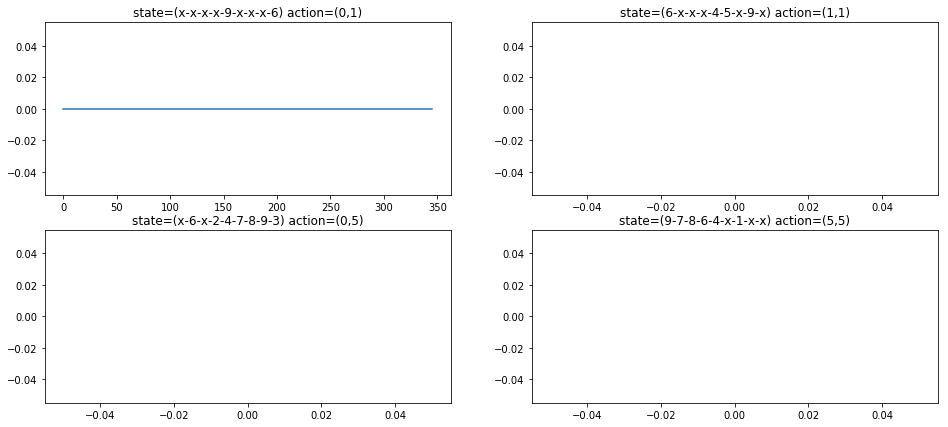

In [114]:
plt.figure(0, figsize=(16,7))
plt.subplot(221)
plt.title('state=(x-x-x-x-9-x-x-x-6) action=(0,1)')
xaxis = np.asarray(range(0, len(States_track['x-x-x-x-9-x-x-x-6'][(0,1)])))
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-9-x-x-x-6'][(0,1)]))
plt.subplot(222)
plt.title('state=(6-x-x-x-4-5-x-9-x) action=(1,1)')
xaxis = np.asarray(range(0, len(States_track['6-x-x-x-4-5-x-9-x'][(1,1)])))
plt.plot(xaxis,np.asarray(States_track['6-x-x-x-4-5-x-9-x'][(1,1)]))
plt.subplot(223)
plt.title('state=(x-6-x-2-4-7-8-9-3) action=(0,5)')
xaxis = np.asarray(range(0, len(States_track['x-6-x-2-4-7-8-9-3'][(0,5)])))
plt.plot(xaxis,np.asarray(States_track['x-6-x-2-4-7-8-9-3'][(0,5)]))
plt.subplot(224)
plt.title('state=(9-7-8-6-4-x-1-x-x) action=(5,5)')
xaxis = np.asarray(range(0, len(States_track['9-7-8-6-4-x-1-x-x'][(5,5)])))
plt.plot(xaxis,np.asarray(States_track['9-7-8-6-4-x-1-x-x'][(5,5)]))

plt.show()

### Epsilon - decay check

In [115]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

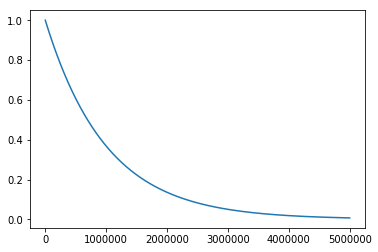

In [116]:
plt.plot(time, epsilon)
plt.show()